In [1]:
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [2]:
0

0

In [3]:
from ganpaint.labwidget import Model, Property, Event
from ganpaint.labwidget import Button, Textbox, Label, Range
from ganpaint import show
import html

prop = Property(30.5)


b = Range(prop)
t = Textbox(prop)
l = Label(t.prop('value'))
show([b, t, l])

In [4]:
from ganpaint import paintwidget
pw = paintwidget.PaintWidget(image='http://wednesday.csail.mit.edu/davidbau/encoder/results/image9-mask.png')
display(pw)

In [5]:
next(iter(dict(a=3)))

'a'

""
tree
""
""
""

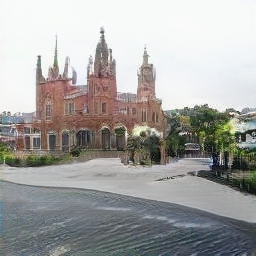

In [6]:
import torch
from ganpaint import nethook, setting, renormalize, zdataset, paintwidget, show
from ganpaint.labwidget import Button

# Load a generator, and paint random image number 20 in a widget.
G = nethook.InstrumentedModel(setting.load_proggan('church')).cuda()
z = zdataset.z_sample_for_model(G)[20][None].cuda()

# Whenever the widget changes, call "changed" to edit the layer and repaint

class GanPaintWidget(Model):
    def __init__(self, G, z, layer, concept_units):
        self.G = G
        self.z = z
        self.layer = layer
        self.canvas = paintwidget.PaintWidget(image=renormalize.as_url(G(z)[0]))
        self.concept_units = concept_units
        self.concept_masks = {}
        self.concept_tensors = {}
        self.reset = Button('reset')
        self.reset.on('click', self.do_reset)
        def setup_button(mode):
            button = Button(mode)
            def setmode():
                self.mode = mode
            button.on('click', setmode)
            setattr(self, mode, button)
        for i, k in enumerate(concept_units):
            setup_button(k)
        self.mode = Property(next(iter(concept_units)))
        def switch_mask(mode):
            self.canvas.mask = self.concept_masks.get(mode, '')
        self.on('mode', switch_mask)
        units = self.concept_units[self.mode]
        logging.debug('units are ' + repr(units))
        def editrule(x, imodel, **buffers):
            for k, a in self.concept_tensors.items():
                x[:,concept_units[k]] += (a * 20.0).to(x.device)
            return x
        self.G.edit_layer(layer, rule=editrule)
        self.canvas.on('mask', self.painted)
        
    def do_reset(self):
        self.concept_masks.clear()
        self.concept_tensors.clear()
        self.canvas.mask = ''
    
    def painted(self, mask):
        logging.debug('got painted call')
        self.concept_masks[self.mode] = mask
        if mask:
            self.concept_tensors[self.mode] = (
                renormalize.from_url(mask, target='pt', size=(8,8))[0])
        else:
            if self.mode in self.concept_tensors:
                del self.concept_tensors[self.mode]
        self.canvas.image = renormalize.as_url(self.G(self.z)[0])
        
    def _repr_html_(self):
        return show.html([(
            self.canvas,
            [(Label(self.prop('mode')),)] +
            [(getattr(self, k),) for k in self.concept_units]
            + [(self.reset,)]
        )])
    
gpw = GanPaintWidget(
    nethook.InstrumentedModel(setting.load_proggan('church')).cuda(),
    zdataset.z_sample_for_model(G)[20][None].cuda(),
    'layer4',
    dict(
        tree=[119, 125, 157, 195, 365, 374, 418, 426, 408, 3, 297, 322, 343],
        dome=[43, 419, 86, 370, 282, 233, 226, 430, 78, 402, 501]
    ))
show(gpw)